# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
! pip install split-folders

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import torch
from torchvision import datasets, transforms
import numpy as np
import splitfolders

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Create Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomRotation(10),
    # -------------
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # Imagenet standards
])

# Split the training folder to new training and validation folders
splitfolders.ratio("/data/landmark_images/train", output="train_valid", seed=1337, ratio=(.8, .2), group_prefix=None)

# Load the image data
train_data = datasets.ImageFolder('./train_valid/train', transform=train_transform)
valid_data = datasets.ImageFolder('./train_valid/val', transform=test_transform)
test_data = datasets.ImageFolder('/data/landmark_images/test', transform=test_transform)

# Save classes names 
n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]


batch_size = 20
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Copying files: 4996 files [00:11, 423.62 files/s]


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- Firstly, I randomly resized crop the images to 224x224 pixels for training. But for testing, I did normal resized to 256, then center crop to 224x224 pixels size. After conducting some research, I have picked 224x224 pixels as the size of the input tensor since it appears a pretty typical and suitable size for an image, and it is inspired by the input image size of vgg-16 that has been trained on the imagenet data.
- I augmented the training set By ranomly do a horizonatal flip 0.3 percentage and by doing a random rotation 10 degrees.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

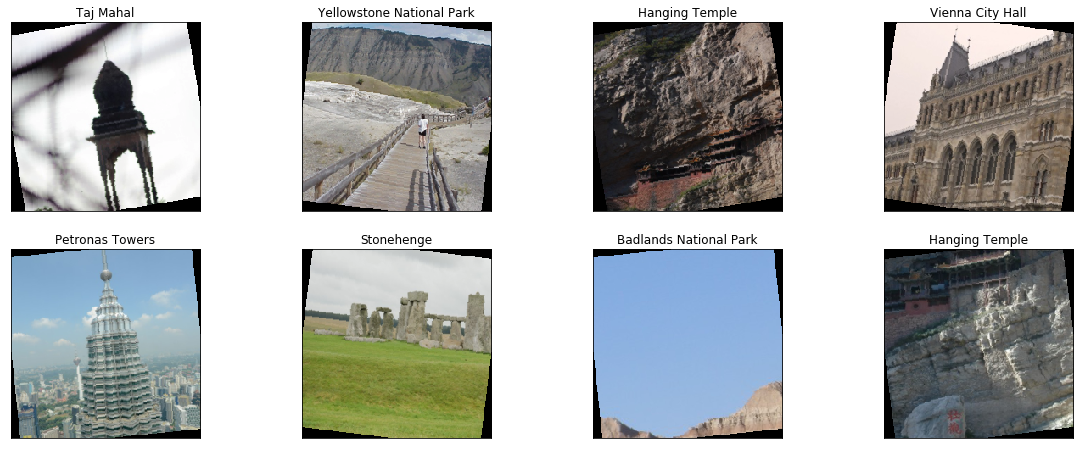

In [3]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
def unnormlize(img, s, m):
    return img * s[:, None, None] + m[:, None, None]


fig = plt.figure(figsize=(20,2*8))
for idx in range(8):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[], )
    rand_img = random.randint(0, len(train_data))

    img = unnormlize(train_data[rand_img][0], torch.Tensor(std), torch.Tensor(mean)) # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # convert from Tensor image
    class_name = classes[train_data[rand_img][1]]
    ax.set_title(class_name)


### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
import torch.optim as optim
import torch.nn as nn

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.01)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        
        # Max pooling layer (divides the image by a factor of 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(28 * 28 * 64, 256)
        self.fc2 = nn.Linear(256, n_classes) # n_classes = 50
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        # Batch norm
        self.batch_norm2d = nn.BatchNorm2d(32)
        self.batch_norm1d = nn.BatchNorm1d(256)
        
    
    def forward(self, x):
        ## Define forward behavior
        # sequence of convolutional and max pooling layers
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.batch_norm2d(x)
        x = self.pool(self.leaky_relu(self.conv3(x)))
        
        # flatten the image
        x = x.view(-1, 28 * 28 * 64)
        
        # dropout layer
        x = self.dropout(x)
        
        # 1st hidden layer
        x = self.leaky_relu(self.fc1(x))
        
        x = self.batch_norm1d(x)
        
        # dropout layer
        x = self.dropout(x)
        
        # final layer
        x = self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [9]:
! pip install torchsummary

In [10]:
from torchsummary import summary 

summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         LeakyReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         LeakyReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
       BatchNorm2d-7           [-1, 32, 56, 56]              64
            Conv2d-8           [-1, 64, 56, 56]          18,496
         LeakyReLU-9           [-1, 64, 56, 56]               0
        MaxPool2d-10           [-1, 64, 28, 28]               0
          Dropout-11                [-1, 50176]               0
           Linear-12                  [-1, 256]      12,845,312
        LeakyReLU-13                  [-1, 256]               0
      BatchNorm1d-14                  [

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
  
<h4>Convolutional and Max pooling layers:</h4>

- Conv1 - 224x224 16 | Leaky relu activation function
- Max pooling using a 2x2 kernel and a stride of 2

- Conv2 - 112x112 32 | Leaky relu activation function

- Max pooling using a 2x2 kernel and a stride of 2
- Batch Normalization

- Conv3 - 56x56 64 | Leaky relu activation function

- Max pooling using a 2x2 kernel and a stride of 2

<h4> Fully connected layers and dropout:</h4>

- Dropout of 30% probability
- Fully connected layer (28x28 64, 256) | Leaky relu activation function
- Batch Normalization

- Dropout of 30% probability

- Fully connected layer (256, n_classes=50)
Dropout has been used to avoid overfitting and Max-pooling layers to focus on the main target features via dividing the image by a factor of 2

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda: # load them in parallel
                data, target = data.cuda(), target.cuda() 
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward() # calculate gradient
            optimizer.step() # update wieghts
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss =valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch,train_loss,valid_loss))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss       
   
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [12]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.zero_()


    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.716991 	Validation Loss: 3.433848
Validation loss decreased (inf --> 3.433848).  Saving model ...
Epoch: 2 	Training Loss: 3.474821 	Validation Loss: 3.286409
Validation loss decreased (3.433848 --> 3.286409).  Saving model ...
Epoch: 3 	Training Loss: 3.397632 	Validation Loss: 3.230874
Validation loss decreased (3.286409 --> 3.230874).  Saving model ...
Epoch: 4 	Training Loss: 3.326449 	Validation Loss: 3.129153
Validation loss decreased (3.230874 --> 3.129153).  Saving model ...
Epoch: 5 	Training Loss: 3.232992 	Validation Loss: 3.136491
Epoch: 6 	Training Loss: 3.201895 	Validation Loss: 3.020016
Validation loss decreased (3.129153 --> 3.020016).  Saving model ...
Epoch: 7 	Training Loss: 3.159094 	Validation Loss: 2.993792
Validation loss decreased (3.020016 --> 2.993792).  Saving model ...
Epoch: 8 	Training Loss: 3.096793 	Validation Loss: 2.932733
Validation loss decreased (2.993792 --> 2.932733).  Saving model ...
Epoch: 9 	Training Loss: 3.045547 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [13]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.683436 	Validation Loss: 3.468195
Validation loss decreased (inf --> 3.468195).  Saving model ...
Epoch: 2 	Training Loss: 3.464255 	Validation Loss: 3.346626
Validation loss decreased (3.468195 --> 3.346626).  Saving model ...
Epoch: 3 	Training Loss: 3.355563 	Validation Loss: 3.255592
Validation loss decreased (3.346626 --> 3.255592).  Saving model ...
Epoch: 4 	Training Loss: 3.295266 	Validation Loss: 3.186606
Validation loss decreased (3.255592 --> 3.186606).  Saving model ...
Epoch: 5 	Training Loss: 3.203866 	Validation Loss: 3.180848
Validation loss decreased (3.186606 --> 3.180848).  Saving model ...
Epoch: 6 	Training Loss: 3.164857 	Validation Loss: 3.023705
Validation loss decreased (3.180848 --> 3.023705).  Saving model ...
Epoch: 7 	Training Loss: 3.109055 	Validation Loss: 2.970729
Validation loss decreased (3.023705 --> 2.970729).  Saving model ...
Epoch: 8 	Training Loss: 3.071611 	Validation Loss: 2.947118
Validation loss decreased (2.97072

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.506284


Test Accuracy: 38% (485/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


loaders_transfer = loaders_scratch.copy()





### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [16]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    return optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
## TODO: Specify model architecture
import torch.nn as nn
from torchvision import models

model_transfer = models.vgg16(pretrained=True)

#freezing features- weights
for param in model_transfer.features.parameters():
    param.require_grad =False
    
# replace last layer    
model_transfer.classifier[6] = nn.Linear(model_transfer.classifier[6].in_features , len(classes) )

print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 112962501.29it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__
I used the VGG-16 model as a pretrained model because it has been trained on millions of images. Since we have a small dataset and quite similar data, I only replaced the last fully connected layer of the model with one of our own problem to output 50 classes. Additionally, I froze the parameters of all the features layers of the model and left the parameters of the classifier part for training.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [18]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 15


# train the model
train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                  criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.542184 	Validation Loss: 1.533748
Validation loss decreased (inf --> 1.533748).  Saving model ...
Epoch: 2 	Training Loss: 1.697662 	Validation Loss: 1.252728
Validation loss decreased (1.533748 --> 1.252728).  Saving model ...
Epoch: 3 	Training Loss: 1.520272 	Validation Loss: 1.168987
Validation loss decreased (1.252728 --> 1.168987).  Saving model ...
Epoch: 4 	Training Loss: 1.390203 	Validation Loss: 1.102640
Validation loss decreased (1.168987 --> 1.102640).  Saving model ...
Epoch: 5 	Training Loss: 1.297983 	Validation Loss: 1.094523
Validation loss decreased (1.102640 --> 1.094523).  Saving model ...
Epoch: 6 	Training Loss: 1.206773 	Validation Loss: 1.054887
Validation loss decreased (1.094523 --> 1.054887).  Saving model ...
Epoch: 7 	Training Loss: 1.176499 	Validation Loss: 1.025826
Validation loss decreased (1.054887 --> 1.025826).  Saving model ...
Epoch: 8 	Training Loss: 1.117746 	Validation Loss: 1.011526
Validation loss decreased (1.02582

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.818731


Test Accuracy: 77% (969/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [25]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img = transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    model_transfer.eval()
    output = model_transfer(img)
    top_values, top_idx = output.topk(k)

    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Eiffel Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

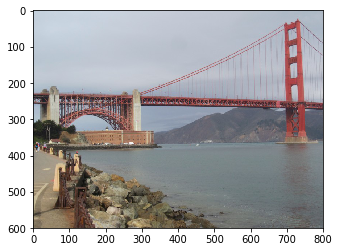

Is this picture of the
Golden Gate Bridge ,  Forth Bridge , or  Brooklyn Bridge ?


In [26]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    
    plt.imshow(img)
    plt.show()
    
    print('Is this picture of the')
    print(predicted_landmarks[0],', ',predicted_landmarks[1],', or ',predicted_landmarks[2],'?')

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
- Feeding the model with more related data.
- Hyperparameters tuning: Using adaptive learning rate, more epochs, tuning momentum.
- Add more hidden layers

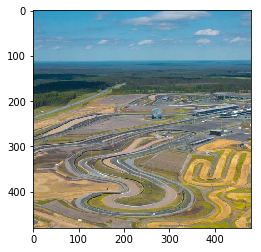

Is this picture of the
Moscow Raceway ,  Eiffel Tower , or  Seattle Japanese Garden ?


In [43]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('my_test_pics/Moscow_raceway.jpg')


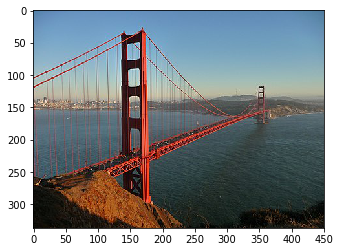

Is this picture of the
Golden Gate Bridge ,  Brooklyn Bridge , or  Forth Bridge ?


In [41]:
suggest_locations('my_test_pics/Golden_Gate_Bridge.JPG')

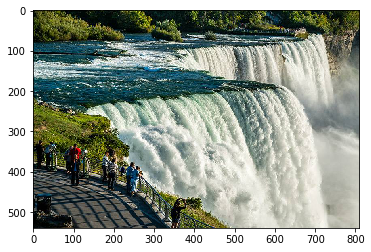

Is this picture of the
Niagara Falls ,  Banff National Park , or  Gullfoss Falls ?


In [45]:
suggest_locations('my_test_pics/Niagara_Falls.jpg')

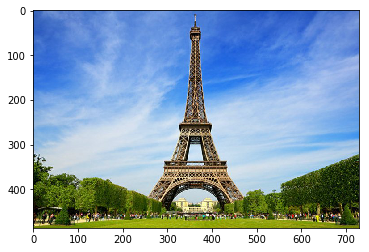

Is this picture of the
Eiffel Tower ,  Whitby Abbey , or  Terminal Tower ?


In [46]:
suggest_locations('my_test_pics/eiffel.jpg')
